# General Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torch.optim import lr_scheduler
from torchvision import models,transforms,datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion()

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/home/nkumar/packenv/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/nkumar/packenv/lib/python3.8/site-packages/torch/cuda/__init__.py:749: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() if nvml_count < 0 else nvml_count


# Load the Model 

In [2]:
model_ft = models.vgg11_bn(weights='IMAGENET1K_V1')
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, 4)

In [3]:
# Load the model weights
model_ft.load_state_dict(torch.load('/home/nkumar/github/models/tom_jerry.pt',map_location=torch.device('cpu')))
# Set the model to evaluation mode
model_ft.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

# Model Predictions

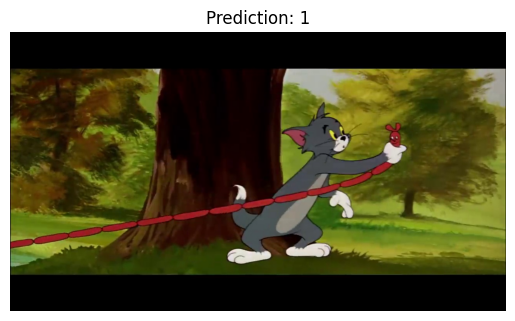

In [4]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize(256),                  # Resize to 256x256
    transforms.CenterCrop(224),              # Crop center 224x224
    transforms.ToTensor(),                   # Convert to Tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Load an image
image_path = '/home/nkumar/github/DeepLearning-Projects/Image_classification/VGG/assets/tom.jpg'  # Replace with your image path
image = Image.open(image_path)

# Apply transformations
input_tensor = transform(image)
input_batch = input_tensor.unsqueeze(0)  # Add batch dimension


# Make predictions
with torch.no_grad():
    input_batch = input_batch.to(device)
    output = model_ft(input_batch)

# Convert output probabilities to predicted class
probabilities = torch.nn.functional.softmax(output[0], dim=0)
predicted_class = torch.argmax(probabilities).item()

# Load Image and Display with Prediction
plt.imshow(np.asarray(image))
plt.axis('off')
plt.title(f'Prediction: {predicted_class}')
plt.show()

# Grad Cam

In [5]:
#Inistall Grad Cam for Kernal visualization
#!pip install git+https://github.com/jacobgil/pytorch-grad-cam.git

# Grad Cam With Live Inference

In [8]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# Initialize Grad-CAM
target_layers = [model_ft.features[-1]]  # Assuming this is the layer you want to visualize
cam = GradCAM(model=model_ft, target_layers=target_layers)

# Open the video file
video_path = '/home/nkumar/github/DeepLearning-Projects/Image_classification/VGG/assets/demo_tom_jerry.mp4'  # Replace with your video path
cap = cv2.VideoCapture(video_path)

# Check if video opened successfully
if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

# Get video properties
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FPS))

# Define the codec and create VideoWriter object
output_path = 'output_Jerry_video.mp4'  # Replace with your desired output path
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Define the codec
out = cv2.VideoWriter(output_path, fourcc, fps, (frame_width, frame_height))

# Define transforms for image preprocessing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize each frame to match model input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Set model to evaluation mode
model_ft.eval()

# Read and process each frame
while True:
    ret, frame = cap.read()
    if not ret:
        break  # Break the loop when no more frames are available
    
    # Convert frame from BGR to RGB (OpenCV default)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Convert the frame to PIL format
    frame_pil = Image.fromarray(frame_rgb)

    # Prepare input tensor
    input_tensor = transform(frame_pil)
    input_tensor = input_tensor.unsqueeze(0)  # Add batch dimension

    # Move input tensor to GPU if available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_tensor = input_tensor.to(device)

    # Generate CAM for the frame
    with torch.no_grad():
        outputs = model_ft(input_tensor)
        _, predicted_class = torch.max(outputs, 1)

    # Now we need to enable gradient calculation for CAM generation
    model_ft.zero_grad()
    target = ClassifierOutputTarget(predicted_class.item())
    grayscale_cam = cam(input_tensor=input_tensor, targets=[target])

    # Resize the CAM to the original frame size
    grayscale_cam = cv2.resize(grayscale_cam[0], (frame.shape[1], frame.shape[0]))

    # Convert tensors to numpy arrays
    frame_rgb_np = frame_rgb / 255.0  # Normalize to [0, 1]
    cam_image = show_cam_on_image(frame_rgb_np, grayscale_cam, use_rgb=True)

    # Convert cam_image to BGR format for OpenCV
    cam_image_bgr = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

    # Overlay classification label
    label_text = f'Class: {predicted_class.item()}'
    cv2.putText(cam_image_bgr, label_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 0, 0), 2, cv2.LINE_AA)

    # Write the frame with CAM to the video
    out.write(cam_image_bgr)

    # Display the original frame and Grad-CAM heatmap (optional, for debugging)
    cv2.imshow('Original Frame', frame)
    cv2.imshow('Grad-CAM Heatmap', cam_image_bgr)

    # Press 'q' to quit (optional, for debugging)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release the video capture and writer objects and close all windows
cap.release()
out.release()
cv2.destroyAllWindows()


In [7]:
#destroyAllWindows
cv2.destroyAllWindows()